In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msn
import dexplot as dxp
import numpy as np
from scipy.stats import spearmanr
from datetime import timedelta

In [2]:

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb

In [24]:

train=pd.read_csv("../training_set_VU_DM.csv")

In [25]:
## dropping columns with high nulls

to_drop= ['comp1_rate',
'comp1_inv',
'comp1_rate_percent_diff',
'comp2_rate',
'comp2_inv',
'comp2_rate_percent_diff',
'comp3_rate',
'comp3_inv',
'comp3_rate_percent_diff',
'comp4_rate',
'comp4_inv',
'comp4_rate_percent_diff',
'comp5_rate',
'comp5_inv',
'comp5_rate_percent_diff',
'comp6_rate',
'comp6_inv',
'comp6_rate_percent_diff',
'comp7_rate',
'comp7_inv',
'comp7_rate_percent_diff',
'comp8_rate',
'comp8_inv',
'comp8_rate_percent_diff']


#creating dependant variable 

conditions = [
    (train['click_bool']> 0)
]

choices = [1]
train['outcome'] = np.select(conditions, choices, default=0)

train = train.drop(to_drop,  axis=1)#.sample(frac=0.2, replace=True, random_state=1)

#filtering out price outliers 
train = train[train.price_usd < 3001]

In [26]:
train.head() # 30 columns

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool,outcome
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,0,1,1,NaN,NaN,1,0,NaN,0,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,0,1,1,NaN,NaN,1,0,NaN,0,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,0,1,1,NaN,NaN,1,0,NaN,0,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,0,1,1,NaN,NaN,1,0,NaN,0,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,0,1,1,NaN,NaN,1,0,NaN,0,0


In [27]:
# train['id_with_booking'] = train.groupby('srch_id')['booking_bool'].transform('sum')
# print(np.unique(train['id_with_booking']))

# train2 = train.drop(train[(train['id_with_booking'] == 0)].index)
# train2 = train2.drop(['id_with_booking'],  axis=1)#.sample(frac=0.2, replace=True, random_state=1)

# train = train2

In [28]:
## creating time related features
    
train['date_time'] = pd.to_datetime(train['date_time'], errors='coerce')
train["weekday"] = train["date_time"].dt.weekday
train["week_of_year"] = train["date_time"].dt.week
train["month"] = train["date_time"].dt.month
train["hour"] = train["date_time"].dt.hour
## total time elapsed - allows model to learn continous trend over time to a degree
train["time_epoch"] = train["date_time"].astype('int64')//1e9
train.loc[ train['hour'] < 6, 'day_time'] = 1
train.loc[(train['hour'] >=6) & (train['hour'] <= 11), 'day_time'] = 2
train.loc[(train['hour'] >= 12) & (train['hour'] <= 17), 'day_time'] = 3
train.loc[(train['hour'] > 18) , 'day_time'] = 4

<ipython-input-28-8a4ad4be83d5>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train["week_of_year"] = train["date_time"].dt.week


In [29]:
#more time related features

train['srch_for_date'] = train['date_time']  + pd.to_timedelta(train['srch_booking_window'], unit='D')
train["srch_for_month"] = train["srch_for_date"].dt.month
train.loc[ train['srch_for_month'] <= 3, 'seasonality'] = 1
train.loc[(train['srch_for_month'] > 3) & (train['srch_for_month'] <= 6), 'seasonality'] = 2
train.loc[(train['srch_for_month'] > 6) & (train['srch_for_month'] <= 9), 'seasonality'] = 3
train.loc[(train['srch_for_month'] > 9) , 'seasonality'] = 4

train.loc[ train['month'] <= 3, 'qrtr'] = 1
train.loc[(train['month'] > 3) & (train['month'] <= 6), 'qrtr'] = 2
train.loc[(train['month'] > 6) & (train['month'] <= 9), 'qrtr'] = 3
train.loc[(train['month'] > 9) , 'qrtr'] = 4

In [30]:
#filling in missing values for prop_review_score and prop_starrating using average rating 
#based off similar priced hotels 
train['price_bin'] = pd.qcut(train['price_usd'], q=80, precision=0)
train['mean_price_bin_star'] = train.groupby('price_bin')['prop_starrating'].transform('mean')
train['mean_price_bin_review'] = train.groupby('price_bin')['prop_review_score'].transform('mean')
train['prop_review_score'] = train['prop_review_score'].fillna(0)
train.loc[train.prop_review_score == 0, "prop_review_score"] = train.mean_price_bin_review
train.loc[train.prop_starrating == 0, "prop_starrating"] = train.mean_price_bin_star

In [31]:
#comparing price for hotels with other hotels in the same search

train['max_price'] = train.groupby('srch_id')['price_usd'].transform('max') 
train['min_price'] = train.groupby('srch_id')['price_usd'].transform('min') 
train['mean_price'] = train.groupby('srch_id')['price_usd'].transform('mean') 
train['diff_max_price'] =(train['max_price'] -train['price_usd']) / train['price_usd']
train['diff_min_price'] = (train['min_price'] - train['price_usd'])/ train['price_usd']
train['diff_min_price'] = train['diff_min_price'].replace(np.nan, 0)
train['diff_mean_price'] = (train['mean_price'] - train['price_usd']) / train['price_usd']
train['price_review_value'] =  train['prop_review_score'] /train['mean_price_bin_review'] 


In [32]:
# getting actual click and booking statistics for each hotel & if there was a booking - how many adults,children,rooms

train['hotel_show_prob'] =  train.groupby('prop_id')['prop_id'].transform('count') / (train.srch_id.unique()).size
train_calcs = train[train.booking_bool == 1]
train_calcs['hotel_avg_children'] = train_calcs.groupby('prop_id')['srch_children_count'].transform('mean') 
train_calcs['hotel_avg_adult'] = train_calcs.groupby('prop_id')['srch_adults_count'].transform('mean') 
train_calcs['hotel_avg_stay'] = train_calcs.groupby('prop_id')['srch_length_of_stay'].transform('mean') 
train_calcs['hotel_avg_room_count'] = train_calcs.groupby('prop_id')['srch_room_count'].transform('mean') 
train_calcs['bought'] = train_calcs.groupby('prop_id')['booking_bool'].transform('sum') 
train_calcs = train_calcs[['prop_id','hotel_avg_children', 'hotel_avg_adult', 'hotel_avg_stay','hotel_avg_room_count','bought']]

#pd.crosstab(train.hotel_click_prob, train.prop_id, dropna=False)
train_calcs = train_calcs.drop_duplicates(subset=['prop_id'])

train['hotel_buy_prob'] = train.groupby('prop_id')['booking_bool'].transform('sum') / train.groupby('prop_id')['booking_bool'].transform('count')
train['hotel_click_prob'] = train.groupby('prop_id')['click_bool'].transform('sum') / train.groupby('prop_id')['click_bool'].transform('count')
train['hotel_qrtr_buy_prob'] = train.groupby(['qrtr','prop_id'])['booking_bool'].transform('sum') / train.groupby(['qrtr','prop_id'])['booking_bool'].transform('count')
train['hotel_qrtr_click_prob'] = train.groupby(['qrtr','prop_id'])['click_bool'].transform('sum') / train.groupby(['qrtr','prop_id'])['click_bool'].transform('count')
train['hotel_srch_sesn_buy_prob'] = train.groupby(['seasonality','prop_id'])['booking_bool'].transform('sum') / train.groupby(['seasonality','prop_id'])['booking_bool'].transform('count')
train['hotel_srch_sesn_click_prob'] = train.groupby(['seasonality','prop_id'])['click_bool'].transform('sum') / train.groupby(['seasonality','prop_id'])['click_bool'].transform('count')


hotel_click_stats = train[['prop_id', 'hotel_buy_prob','hotel_click_prob', 'hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob','hotel_srch_sesn_click_prob']]

<ipython-input-32-6a465437114b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_calcs['hotel_avg_children'] = train_calcs.groupby('prop_id')['srch_children_count'].transform('mean')
<ipython-input-32-6a465437114b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_calcs['hotel_avg_adult'] = train_calcs.groupby('prop_id')['srch_adults_count'].transform('mean')
<ipython-input-32-6a465437114b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [33]:
## balancing the dataset - at first balanced it 50:50 but now balancing it 33:66
df = train[train.outcome == 1]
df1 = train[train.outcome == 0]
df1 = df1.sample(n=len(df)*2)

frames = [df, df1]

train_reduced = pd.concat(frames)

In [34]:
### merging hotel specific cals to main dataset 
train_reduced = train_reduced.merge(train_calcs, left_on=['prop_id'], right_on=['prop_id'], how='left')
train_reduced['hotel_avg_children'] = train_reduced['hotel_avg_children'].replace(np.nan, .367)
train_reduced['hotel_avg_adult'] = train_reduced['hotel_avg_adult'].replace(np.nan, 1.95)
train_reduced['hotel_avg_stay'] = train_reduced['hotel_avg_stay'].replace(np.nan, 2.09)
train_reduced['hotel_avg_room_count'] = train_reduced['hotel_avg_room_count'].replace(np.nan, 1.13)


In [35]:
train_reduced # 63 columns

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,hotel_click_prob,hotel_qrtr_buy_prob,hotel_qrtr_click_prob,hotel_srch_sesn_buy_prob,hotel_srch_sesn_click_prob,hotel_avg_children,hotel_avg_adult,hotel_avg_stay,hotel_avg_room_count,bought
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,68914,2.0,3.0,...,0.034305,0.032258,0.046083,0.038278,0.047847,0.176471,2.058824,1.235294,1.176471,17.0
1,4,2012-12-31 08:59:22,5,219,NaN,NaN,219,139893,2.0,3.0,...,0.033520,0.000000,0.035088,0.027523,0.036697,0.285714,2.142857,1.285714,1.285714,7.0
2,6,2013-06-05 12:27:51,14,100,NaN,NaN,100,104251,3.0,4.0,...,0.045455,0.071429,0.071429,0.090909,0.090909,0.000000,2.000000,1.000000,1.000000,1.0
3,8,2013-03-20 17:50:44,5,219,NaN,NaN,219,27669,3.0,3.5,...,0.035897,0.049383,0.061728,0.040541,0.040541,0.166667,1.666667,1.833333,1.000000,6.0
4,11,2013-02-25 08:39:33,5,219,NaN,NaN,219,20499,2.0,3.5,...,0.030612,0.000000,0.026316,0.026316,0.052632,0.000000,2.000000,1.000000,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665083,34448,2013-06-17 04:18:12,5,219,NaN,NaN,219,42782,3.0,4.5,...,0.040000,0.090909,0.090909,0.111111,0.111111,0.000000,1.000000,1.000000,1.000000,1.0
665084,159513,2013-02-25 20:22:45,5,219,NaN,NaN,219,74754,4.0,4.5,...,0.014663,0.005263,0.010526,0.007792,0.015584,0.555556,2.111111,2.666667,1.000000,9.0
665085,225537,2013-02-25 07:28:37,5,219,NaN,NaN,219,26016,3.0,4.0,...,0.013216,0.010101,0.030303,0.014085,0.028169,0.000000,2.000000,2.000000,1.000000,1.0
665086,149996,2012-12-17 19:19:29,18,129,NaN,NaN,99,15503,3.0,3.5,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.367000,1.950000,2.090000,1.130000,NaN


In [36]:
#dropped price bin
train_reduced = train_reduced.drop(['price_bin'], axis = 1)

In [37]:
#checking %% of nulls in the dataset 
train_reduced.isnull().mean() * 100

srch_id                         0.00000
date_time                       0.00000
site_id                         0.00000
visitor_location_country_id     0.00000
visitor_hist_starrating        94.93646
                                 ...   
hotel_avg_children              0.00000
hotel_avg_adult                 0.00000
hotel_avg_stay                  0.00000
hotel_avg_room_count            0.00000
bought                         20.46857
Length: 62, dtype: float64

In [38]:
##droppping columns not needed 

to_drop = ['srch_id','site_id', 'date_time', 'visitor_location_country_id', 'prop_country_id', 'prop_id', 'prop_brand_bool', 'orig_destination_distance', 'click_bool', 'booking_bool', 'srch_destination_id', 'position', 'prop_location_score2'
          ,'gross_bookings_usd', 'price_usd', 'max_price','min_price', 'mean_price', 'mean_price_bin_review','mean_price_bin_star', 'bought', 'weekday', 'week_of_year', 'hour', 'time_epoch'] 
#'room_count_grt_1_flag',
train1 = train_reduced.drop(to_drop,  axis=1)

In [39]:
# todo: delete!!

to_drop = ['site_id', 'date_time', 'visitor_location_country_id', 'prop_country_id', 'prop_id', 'prop_brand_bool', 'orig_destination_distance', 'click_bool', 'booking_bool', 'srch_destination_id', 'prop_location_score2'
          ,'gross_bookings_usd', 'price_usd', 'max_price','min_price', 'mean_price', 'mean_price_bin_review','mean_price_bin_star', 'bought', 'weekday', 'week_of_year', 'hour', 'time_epoch'] 
#'room_count_grt_1_flag',
train1 = train_reduced.drop(to_drop,  axis=1)

In [ ]:
#train1.head() # 39 columns

In [40]:
##changing nan or null values to 0
train1.replace([np.inf, -np.inf], 0, inplace=True)

train1=train1.dropna(axis=1,how="any")
#msn.bar(train1,figsize=(18,3), color='red')

In [41]:
##ordering columns and selecting predictors + outcome
train1 = train1[['prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool', 'hotel_click_prob', 'hotel_buy_prob','diff_max_price','diff_min_price','diff_mean_price','hotel_show_prob', 'prop_review_score','price_review_value', 'hotel_avg_children','hotel_avg_adult','hotel_avg_stay','hotel_avg_room_count','random_bool','qrtr','hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob','hotel_srch_sesn_click_prob','outcome']]
#train1 = train1[['srch_id', 'position', 'prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool', 'hotel_click_prob', 'hotel_buy_prob','diff_max_price','diff_min_price','diff_mean_price','hotel_show_prob', 'prop_review_score','price_review_value', 'hotel_avg_children','hotel_avg_adult','hotel_avg_stay','hotel_avg_room_count','random_bool','qrtr','hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob','hotel_srch_sesn_click_prob','outcome']]

In [42]:
#train1.head() # 31 columns

In [44]:
#splitting dataset 
X = train1.iloc[:, :-1].values
y = train1.iloc[:, -1].values

In [45]:
# # Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [ ]:
# X_train[0]

In [46]:

##list of models we can use, can take along time to do them all so try one or two at a time. 

models_list=[
    LogisticRegression(),
  #  Lasso(),
   # RandomForestClassifier(criterion='entropy', min_samples_leaf=60,
             #          min_samples_split=4, random_state=16),
    #GradientBoostingClassifier(),
    lgb.LGBMClassifier(),
   # LinearSVC(random_state=42, C=0.01),
    #xgb.XGBRegressor(objective="reg:linear", random_state=42)   
  #  xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.1), 
 #   xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.05), #better. 
  #  xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.01), 
    #  "multi:softprob"
]

In [47]:
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

#loop thorugh list of models to use. Train them and give an acuracy score

import warnings
warnings.filterwarnings('ignore')

l=[]
for model in models_list:
    #clf=clf_models(model)
    print(model)
    fit_model=model.fit(X_train, y_train)
    score=model.score(X_test, y_test)
    print("model score: %.3f" % score)
    l.append([model,'clf', score, X_test, y_test])
    #print(clf)
    #scores = -1 * cross_val_score(clf, X, y,cv=5,scoring='neg_mean_absolute_error')
    #print("MAE scores:\n", scores.mean(), scores.sum(), scores.min())
    
#print(l[3][4])
#print(l[2][3])
#print(l[2][0])

LogisticRegression()
model score: 0.757
LGBMClassifier()
model score: 0.807


In [48]:
## using the lost of models we select on and use it to predict the test data with an output 

y_pred=l[1][0].predict(X_test)

print(y_pred)

y_pred[:5]

[0 1 1 ... 0 1 1]


array([0, 1, 1, 0, 1])

In [49]:
# writing the results to a dataframe to analyse seperatly if needed ( ie how many false negatives, check values ect)

result = pd.DataFrame(y_test, columns=['actual'])
predicted= pd.DataFrame(y_pred, columns=['predicted'])

df = pd.DataFrame(X_test)
df['result'] = result
df['perdicted'] = predicted
df.to_csv('results2.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,result,perdicted
0,4.0,1.10,0.00,0.0,3.0,24.0,2.0,1.0,1.0,0.0,...,2.090000,1.130000,0.0,2.0,0.000000,0.000000,0.000000,0.000000,0,0
1,3.0,1.95,4.58,1.0,1.0,12.0,2.0,0.0,1.0,1.0,...,2.090000,1.130000,1.0,2.0,0.125000,0.000000,0.000000,0.100000,1,1
2,4.0,4.43,5.03,0.0,8.0,55.0,2.0,0.0,1.0,0.0,...,2.090000,1.130000,1.0,2.0,0.250000,0.000000,0.000000,0.285714,1,1
3,4.0,3.04,0.00,0.0,1.0,5.0,1.0,0.0,1.0,1.0,...,1.142857,1.142857,0.0,2.0,0.039370,0.039370,0.029703,0.039604,0,0
4,4.0,2.20,5.49,0.0,4.0,65.0,4.0,0.0,1.0,0.0,...,1.888889,1.222222,0.0,2.0,0.092105,0.026316,0.045455,0.181818,0,1


In [50]:
###################### pred 
to_pred=pd.read_csv("../test_set_VU_DM.csv")

In [ ]:
to_pred

In [51]:
#### import competition dataset 

#to_pred=pd.read_csv("../test_set_VU_DM.csv")
#test=pd.read_csv("test_set_VU_DM.csv")

to_drop= ['comp1_rate',
'comp1_inv',
'comp1_rate_percent_diff',
'comp2_rate',
'comp2_inv',
'comp2_rate_percent_diff',
'comp3_rate',
'comp3_inv',
'comp3_rate_percent_diff',
'comp4_rate',
'comp4_inv',
'comp4_rate_percent_diff',
'comp5_rate',
'comp5_inv',
'comp5_rate_percent_diff',
'comp6_rate',
'comp6_inv',
'comp6_rate_percent_diff',
'comp7_rate',
'comp7_inv',
'comp7_rate_percent_diff',
'comp8_rate',
'comp8_inv',
'comp8_rate_percent_diff'

]

#train['outcome'] = pd.Series(train['booking_bool']> 0, 500 + train['position'] , train['click_bool']> 0, 100 +train['position'] , 0 + train['position'] )



to_pred = to_pred.drop(to_drop,  axis=1)#.sample(frac=0.2, replace=True, random_state=1)
#test_reduced  = test.iloc[: , :N].sample(frac=0.33, replace=True, random_state=1)


In [52]:
# creating same features as test data

to_pred['date_time'] = pd.to_datetime(to_pred['date_time'], errors='coerce')
to_pred["weekday"] = to_pred["date_time"].dt.weekday
to_pred["week_of_year"] = to_pred["date_time"].dt.week
to_pred["month"] = to_pred["date_time"].dt.month
to_pred["hour"] = to_pred["date_time"].dt.hour
to_pred["time_epoch"] = to_pred["date_time"].astype('int64')//1e9
to_pred["time_epoch"] = to_pred["date_time"].astype('int64')//1e9
to_pred.loc[ to_pred['hour'] < 6, 'day_time'] = 1
to_pred.loc[(to_pred['hour'] >=6) & (to_pred['hour'] <= 11), 'day_time'] = 2
to_pred.loc[(to_pred['hour'] >= 12) & (to_pred['hour'] <= 17), 'day_time'] = 3
to_pred.loc[(to_pred['hour'] > 18) , 'day_time'] = 4

##################

to_pred['srch_for_date'] = to_pred['date_time']  + pd.to_timedelta(to_pred['srch_booking_window'], unit='D')
to_pred["srch_for_month"] = to_pred["srch_for_date"].dt.month

#train['srch_for_date'] = train['date_time']  + pd.to_timedelta(train['srch_booking_window'], unit='D')
#train["srch_for_month"] = train["srch_for_date"].dt.month
to_pred.loc[ to_pred['srch_for_month'] <= 3, 'seasonality'] = 1
to_pred.loc[(to_pred['srch_for_month'] > 3) & (to_pred['srch_for_month'] <= 6), 'seasonality'] = 2
to_pred.loc[(to_pred['srch_for_month'] > 6) & (to_pred['srch_for_month'] <= 9), 'seasonality'] = 3
to_pred.loc[(to_pred['srch_for_month'] > 9) , 'seasonality'] = 4

to_pred.loc[ to_pred['month'] <= 3, 'qrtr'] = 1
to_pred.loc[(to_pred['month'] > 3) & (to_pred['month'] <= 6), 'qrtr'] = 2
to_pred.loc[(to_pred['month'] > 6) & (to_pred['month'] <= 9), 'qrtr'] = 3
to_pred.loc[(to_pred['month'] > 9) , 'qrtr'] = 4

####################

to_pred['price_bin'] = pd.qcut(to_pred['price_usd'], q=80, precision=0)
to_pred['mean_price_bin_star'] = to_pred.groupby('price_bin')['prop_starrating'].transform('mean')
to_pred['mean_price_bin_review'] = to_pred.groupby('price_bin')['prop_review_score'].transform('mean')
to_pred['prop_review_score'] = to_pred['prop_review_score'].fillna(0)
to_pred.loc[to_pred.prop_review_score == 0, "prop_review_score"] = to_pred.mean_price_bin_review
to_pred.loc[to_pred.prop_starrating == 0, "prop_starrating"] = to_pred.mean_price_bin_star

##################

to_pred['max_price'] = to_pred.groupby('srch_id')['price_usd'].transform('max') 
to_pred['min_price'] = to_pred.groupby('srch_id')['price_usd'].transform('min') 
to_pred['mean_price'] = to_pred.groupby('srch_id')['price_usd'].transform('mean') 
to_pred['diff_max_price'] =(to_pred['max_price'] -to_pred['price_usd']) / to_pred['price_usd']
to_pred['diff_min_price'] = (to_pred['min_price'] - to_pred['price_usd'])/ to_pred['price_usd']
to_pred['diff_min_price'] = to_pred['diff_min_price'].replace(np.nan, 0)
to_pred['diff_mean_price'] = (to_pred['mean_price'] - to_pred['price_usd']) / to_pred['price_usd']
to_pred['price_review_value'] =  to_pred['prop_review_score'] /to_pred['mean_price_bin_review'] 

#################

to_pred['hotel_show_prob'] =  to_pred.groupby('prop_id')['prop_id'].transform('count') / (to_pred.srch_id.unique()).size


In [53]:
### mergeing hotel specific stats from test dataset 

to_pred_reduced = to_pred.merge(train_calcs, left_on=['prop_id'], right_on=['prop_id'], how='left')
hotel_click_stats = hotel_click_stats.drop_duplicates(subset=['prop_id'])
to_pred_reduced = to_pred_reduced.merge(hotel_click_stats, left_on=['prop_id'], right_on=['prop_id'], how='left')

In [54]:


#train_reduced = train_reduced.merge(train_clacs, on='prop_id', how='right', suffixes=('_1', '_2'))
#to_pred_reduced  = pd.concat([to_pred_reduced.set_index('prop_id'),train_calcs.set_index('prop_id')], axis=1, join='outer').reset_index()
#to_pred_reduced2  = pd.concat([to_pred_reduced.set_index('prop_id'),hotel_click_stats.set_index('prop_id')], axis=1, join='outer').reset_index()
to_pred_reduced['hotel_avg_children'] = to_pred_reduced['hotel_avg_children'].replace(np.nan, .367)
to_pred_reduced['hotel_avg_adult'] = to_pred_reduced['hotel_avg_adult'].replace(np.nan, 1.95)
to_pred_reduced['hotel_avg_stay'] = to_pred_reduced['hotel_avg_stay'].replace(np.nan, 2.09)
to_pred_reduced['hotel_avg_room_count'] = to_pred_reduced['hotel_avg_room_count'].replace(np.nan, 1.13)
to_pred_reduced[['hotel_click_prob', 'hotel_buy_prob']] = to_pred_reduced[['hotel_click_prob', 'hotel_buy_prob']].fillna(0)


#train_reduced.to_csv('hotel_calcs2.csv')

In [55]:
to_pred_reduced.isnull().mean() * 100

srch_id                         0.000000
date_time                       0.000000
site_id                         0.000000
visitor_location_country_id     0.000000
visitor_hist_starrating        94.889662
visitor_hist_adr_usd           94.865606
prop_country_id                 0.000000
prop_id                         0.000000
prop_starrating                 0.000000
prop_review_score               0.000000
prop_brand_bool                 0.000000
prop_location_score1            0.000000
prop_location_score2           21.939743
prop_log_historical_price       0.000000
price_usd                       0.000000
promotion_flag                  0.000000
srch_destination_id             0.000000
srch_length_of_stay             0.000000
srch_booking_window             0.000000
srch_adults_count               0.000000
srch_children_count             0.000000
srch_room_count                 0.000000
srch_saturday_night_bool        0.000000
srch_query_affinity_score      93.584467
orig_destination

In [56]:
###droppping unused columns 

to_drop = ['site_id', 'date_time', 'visitor_location_country_id', 'prop_country_id','price_bin', 'prop_brand_bool', 'orig_destination_distance', 'srch_destination_id', 'prop_location_score2'
          ,'price_usd','price_bin', 'max_price', 'srch_query_affinity_score','visitor_hist_starrating', 'visitor_hist_adr_usd', 'min_price', 'mean_price', 'mean_price_bin_review','mean_price_bin_star', 'bought',  'weekday', 'week_of_year', 'hour', 'time_epoch'] 

to_pred1 = to_pred_reduced.drop(to_drop,  axis=1)

In [ ]:
msn.bar(to_pred1,figsize=(18,3), color='red')

<AxesSubplot:>

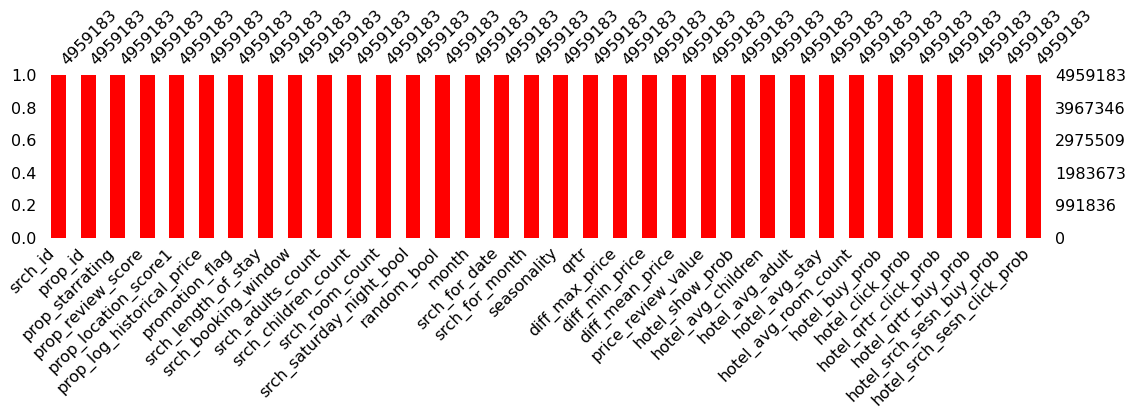

In [57]:
#replacing nulls and nans

to_pred1.replace([np.inf, -np.inf], 0, inplace=True)

to_pred1[['hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob', 'hotel_srch_sesn_click_prob']] = to_pred1[['hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob', 'hotel_srch_sesn_click_prob']].replace(np.nan, 0)

to_pred1=to_pred1.dropna(axis=1,how="any")
msn.bar(to_pred1,figsize=(18,3), color='red')

In [58]:
##ordering df and selecting predictors
to_pred1 = to_pred1[['prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool', 'hotel_click_prob', 'hotel_buy_prob','diff_max_price','diff_min_price','diff_mean_price','hotel_show_prob', 'prop_review_score','price_review_value', 'hotel_avg_children','hotel_avg_adult','hotel_avg_stay','hotel_avg_room_count','random_bool','qrtr','hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob','hotel_srch_sesn_click_prob', 'srch_id', 'prop_id']]

In [ ]:
to_pred1.dtypes

In [59]:
## saving serch_id and prod_id for use in submission file 

ids = to_pred1[['srch_id', 'prop_id']]

to_drop = ['srch_id','prop_id']

to_pred1 = to_pred1.drop(to_drop,  axis=1)

###### perdicitng outcome using model

y_pred=l[1][0].predict(to_pred1)

print(y_pred)

y_pred[:5]

[0 0 0 ... 0 1 0]


array([0, 0, 0, 0, 0])

In [60]:

###creating submission file

predicted= pd.DataFrame(y_pred, columns=['predicted'])

df = pd.DataFrame(to_pred1)

df['perdicted'] = predicted

df[['srch_id', 'prop_id']] = ids[['srch_id', 'prop_id']]

df = df[['srch_id', 'prop_id', 'perdicted','hotel_buy_prob']]

##ordering submission file 


df = df.sort_values(['srch_id', 'perdicted', 'hotel_buy_prob'],
              ascending = [True, False,False])
df = df.drop(['perdicted', 'hotel_buy_prob'], axis = 1)
df.to_csv('submission.csv', index=False)

df.head(5)

,srch_id,prop_id
5,1,28181
1,1,5543
9,1,54937
23,1,99484
0,1,3180
